# Redução de Dimensionalidade 

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.


## _Setup_ geral

In [2]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [3]:
fifa = pd.read_csv("fifa.csv")

In [4]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

# Visão Geral

In [5]:
fifa.shape

(18207, 37)

In [6]:
fifa.info() # Todos os dados são númericos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              18207 non-null  int64  
 1   Overall          18207 non-null  int64  
 2   Potential        18207 non-null  int64  
 3   Crossing         18159 non-null  float64
 4   Finishing        18159 non-null  float64
 5   HeadingAccuracy  18159 non-null  float64
 6   ShortPassing     18159 non-null  float64
 7   Volleys          18159 non-null  float64
 8   Dribbling        18159 non-null  float64
 9   Curve            18159 non-null  float64
 10  FKAccuracy       18159 non-null  float64
 11  LongPassing      18159 non-null  float64
 12  BallControl      18159 non-null  float64
 13  Acceleration     18159 non-null  float64
 14  SprintSpeed      18159 non-null  float64
 15  Agility          18159 non-null  float64
 16  Reactions        18159 non-null  float64
 17  Balance     

In [7]:
fifa.isna().sum() # Há dados faltantes para 48 jogadores

Age                 0
Overall             0
Potential           0
Crossing           48
Finishing          48
HeadingAccuracy    48
ShortPassing       48
Volleys            48
Dribbling          48
Curve              48
FKAccuracy         48
LongPassing        48
BallControl        48
Acceleration       48
SprintSpeed        48
Agility            48
Reactions          48
Balance            48
ShotPower          48
Jumping            48
Stamina            48
Strength           48
LongShots          48
Aggression         48
Interceptions      48
Positioning        48
Vision             48
Penalties          48
Composure          48
Marking            48
StandingTackle     48
SlidingTackle      48
GKDiving           48
GKHandling         48
GKKicking          48
GKPositioning      48
GKReflexes         48
dtype: int64

In [8]:
fifa.columns

Index(['Age', 'Overall', 'Potential', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')

Media de idade dos jogadores: 25 anos
Pontuação geral média:  66

In [9]:
fifa.describe()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,25.122206,66.238699,71.307299,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,4.669943,6.908930,6.136496,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,46.000000,48.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,62.000000,67.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,66.000000,71.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,71.000000,75.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,45.000000,94.000000,95.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


In [10]:
fifac = fifa.dropna()

# Análise Exploratória de Dados

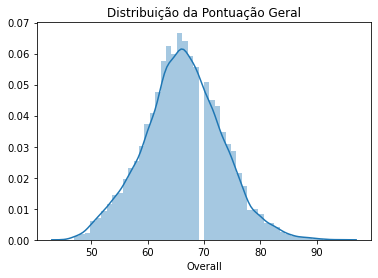

In [11]:
sns.distplot(fifac.Overall);
plt.title('Distribuição da Pontuação Geral');

In [12]:
fifac.Overall.skew() # É bem próxima a uma distribuição normal!

0.06294393052137864

In [13]:
# Há mais jogadores com o pontuação 66 
fifac.Overall.mode()

0    66
dtype: int64

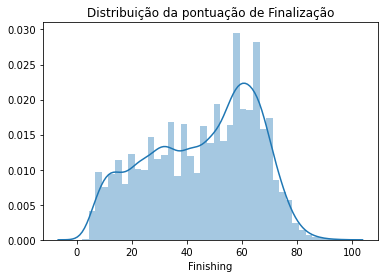

In [14]:
# Pontuação de finalização está longe se aproximar a uma distribuição normal
sns.distplot(fifac.Finishing);
plt.title('Distribuição da pontuação de Finalização');

In [15]:
fifac.Finishing.skew() # Assimetria negativa

-0.30088493202105276

# Resolução das questões

Text(0, 0.5, 'cumulative explained variance')

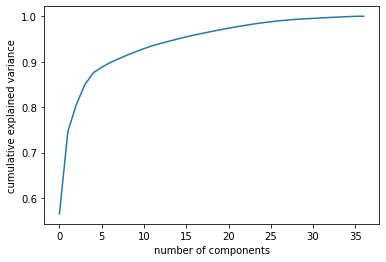

In [16]:
# Questão 1
variancia_explicada = PCA().fit(fifac)

plt.plot(np.cumsum(variancia_explicada.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [17]:
float(variancia_explicada.explained_variance_ratio_[0].round(3))

0.565

In [18]:
# Chegando a fração de variância explicada para cada componente principal de Fifa
for i in variancia_explicada.explained_variance_ratio_:
    print(i)

0.565280555000852
0.1810252191272865
0.05952833907096541
0.04342692843119829
0.026353232565254837
0.012070769547131585
0.01035504945856499
0.008529511313111611
0.007878629794218215
0.007204166769082679
0.007181802971844676
0.006328935424637637
0.005192422862558396
0.004907982933296993
0.004742090417078557
0.004627720079545492
0.004251732462547118
0.003862884317602389
0.0037658844751173154
0.0037509261486773264
0.0034781521279900387
0.0032673070929302036
0.003031379441187911
0.002974158449030382
0.0025679754256991497
0.0023035334246998725
0.00214815132087454
0.0015613590399847113
0.001553516961320226
0.0010866422729046998
0.0010682418854088876
0.0010589152547679844
0.0009581437464860343
0.0008892093940257774
0.0008597324296303794
0.0007346110451538854
0.00019418751733354253


In [19]:
# questão 2
variancia_explicada_acumulada = np.cumsum(variancia_explicada.explained_variance_ratio_)
numero_de_componentes = np.argmax(variancia_explicada_acumulada >= 0.95) + 1 # Contagem começa em zero, e queremos a contagem e não o índice
int(numero_de_componentes)

15

In [20]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [21]:
# Questão 3
pca = PCA(n_components=2)
pca.fit(fifac)
coord1, coord2 = pca.components_.dot(x).round(3)
(coord1, coord2)

(186.556, -6.592)

In [22]:
# questão 4
regressor = LinearRegression()
r_f_e = RFE(regressor, n_features_to_select = 5)
df = fifac.drop(columns='Overall')
y = fifac.Overall
r_f_e.fit(df, y)
list(df.columns[r_f_e.support_])

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [34]:
def q1():
    variancia_explicada = PCA().fit(fifac)
    return float(variancia_explicada.explained_variance_ratio_[0].round(3))

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [30]:
def q2():
    variancia_explicada_acumulada = np.cumsum(variancia_explicada.explained_variance_ratio_)
    numero_de_componentes = np.argmax(variancia_explicada_acumulada >= 0.95) + 1 # Contagem começa em zero, e queremos a contagem e não o índice
    return int(numero_de_componentes)

In [33]:
# Seria possível resolver assim também:
p_c_a = PCA(n_components=0.95)
pca_n_components = p_c_a.fit(fifac).n_components_
int(pca_n_components)

15

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [26]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [27]:
def q3():
    pca = PCA(n_components=2)
    pca.fit(fifac)
    coord1, coord2 = pca.components_.dot(x).round(3)
    return (coord1, coord2)

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

* Não é necessário fazer a regressão em si.
* Muito importante usar a instância `n_features_to_select` do `RFE()`

In [28]:
def q4():
    regressor = LinearRegression()
    r_f_e = RFE(regressor, n_features_to_select = 5)
    df = fifac.drop(columns='Overall')
    y = fifac.Overall
    r_f_e.fit(df, y)
    return list(df.columns[r_f_e.support_])